# "Creating Data with Generative AI"



## In this notebook we will focus on dialogue summarization using generative AI. The focus will be on understanding how the model's output is influenced by the input text and applying prompt engineering techniques to tailor it to specific tasks. Through the comparison of zero-shot, one-shot, and few-shot inferences, you'll delve into prompt engineering, gaining insights into how it can optimize the generative capabilities of Large Language Models.

Outline:

1. Set up Kernel and Install Necessary Dependencies
2. Perform Dialogue Summarization without Prompt Engineering
3. Dialogue Summarization with an Instruction Prompt

    3.1 Zero-Shot Inference with an Instruction Prompt
    
    3.2 Zero-Shot Inference Using the Prompt Template from FLAN-T5
4. Summarize Dialogue with One-Shot and Few-Shot Inference

    4.1 One-Shot Inference
    4.2 Few-Shot Inference
5. Explore Generative Configuration Parameters for Inference

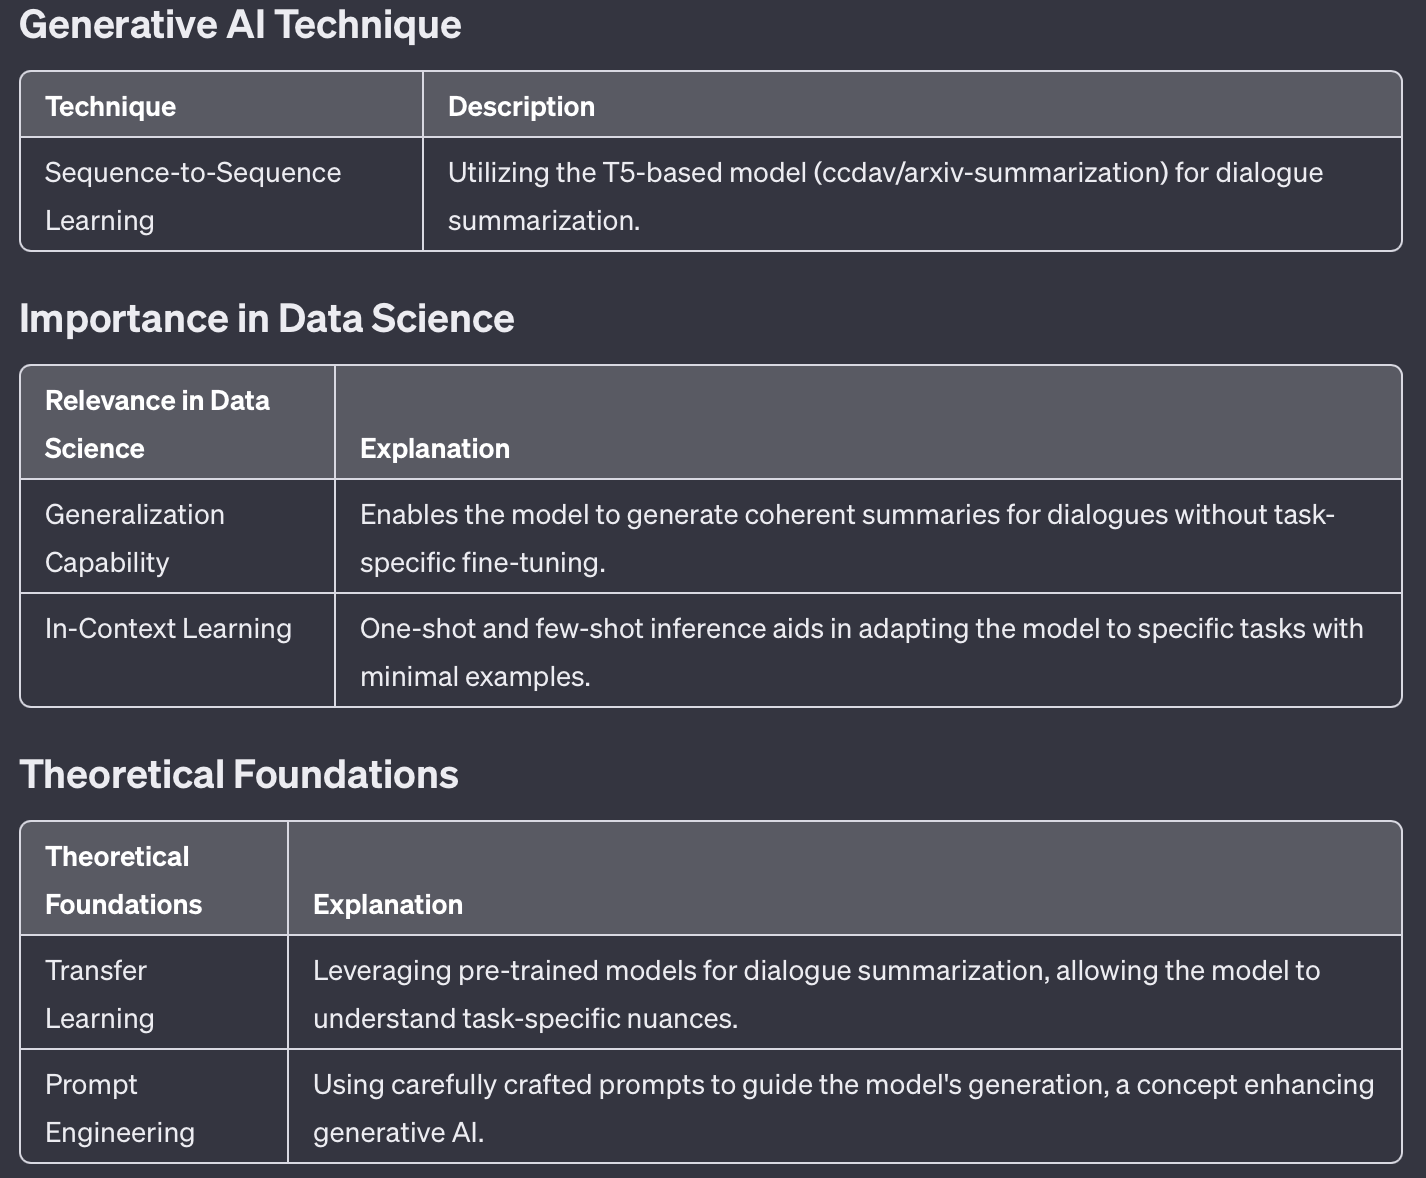



```
# Example of One Shot Inference
prompt = f"""
article:

{article}

What was going on?
"""

inputs = tokenizer(prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

```



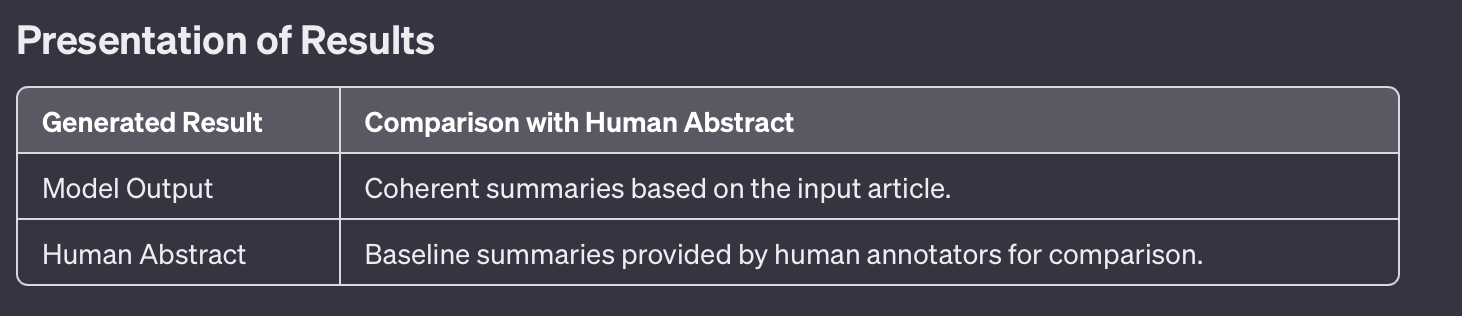

### This code installs and upgrades necessary Python packages for the specified versions, including torch, torchdata, transformers, and datasets, using the pip package manager. The --quiet flag is used to suppress unnecessary output during installation.

In [2]:
%pip install --upgrade pip
%pip install --disable-pip-version-check \
    torch==1.13.1 \
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \
    datasets==2.11.0  --quiet

In [3]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer
from transformers import GenerationConfig

The dataset we're referring to is adapted from a repository related to the summarization of long documents, specifically scientific papers from the arXiv repository. The dataset contains three splits: train, validation, and test, with each instance consisting of three main data fields:

id: A unique identifier for each paper.
article: A string containing the body of the paper, which represents the content of the document.
abstract: A string containing the abstract of the paper, which serves as a concise summary of the document.
The dataset is pre-tokenized, and when using it with the Transformers library's run_summarization.py script, you should include the following line in the summarization_name_mapping variable:



```
"ccdv/arxiv-summarization": ("article", "abstract")

```

The dataset statistics indicate the number of instances in each split and the average token counts based on white space.

This dataset is particularly designed for training and evaluating text summarization models, especially those focused on generating abstractive summaries of long documents. The original paper associated with the dataset introduces a discourse-aware attention model for abstractive summarization of long documents, which takes into account the hierarchical structure of the document and demonstrates superior performance compared to existing models.

To use this dataset for text summarization, you can employ machine learning or deep learning models, such as those provided by the Transformers library. The goal is to train a model that, given the body of a scientific paper (article), generates a concise summary (abstract). You can use the training split to train your model, the validation split to tune hyperparameters and avoid overfitting, and the test split to evaluate the generalization performance of your summarization model on unseen data.


In [4]:
huggingface_dataset_name = "ccdv/arxiv-summarization"

dataset = load_dataset(huggingface_dataset_name)

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 203037
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6436
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 6440
    })
})

## This code selects specific indices from the 'test' split of a dataset, creates a dashed line for formatting, and prints the input article and baseline abstract for each selected example. The examples are identified by their indices (40 and 200), and the output is organized with dashed lines for clarity.

In [6]:
example_indices = [40, 200]

dash_line = '-'.join('' for x in range(100))

for i, index in enumerate(example_indices):
    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print('INPUT ARTICLE:')
    print(dataset['test'][index]['article'])
    print(dash_line)
    print('BASELINE ABSTRACT:')
    print(dataset['test'][index]['abstract'])
    print(dash_line)
    print()

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT ARTICLE:
since the mid 1970 s the existence of heavy hadronic molecules ( composed by a pair of heavy hadrons instead of a pair of heavy quarks ) has been theorized@xcite . 
 this assumption was made based on the similarities between the heavy meson - heavy antimeson system and the deuteron . 
 however , it was not until the discovery of the @xmath0@xcite by the belle collaboration , in 2003 , that the first experimental data that could fit into that molecular scheme was found . 
 since then , many other xyz states have been found , being the @xmath1 also natural candidates to have a molecular structure ..    besides , the @xmath2 limit of qcd simplifies the theory so a set of symmetries are induced . 
 probably , the most important symmetries induced in this limit are hqs

## This code initializes a generative sequence-to-sequence language model using the T5 architecture from the 'google/flan-t5-base' pre-trained model. The model is loaded using the AutoModelForSeq2SeqLM class from the Hugging Face Transformers library.

In [7]:
model_name='google/flan-t5-base'

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

## This code initializes a tokenizer using the 'google/flan-t5-base' pre-trained model with fast tokenization enabled, utilizing the AutoTokenizer class from the Hugging Face Transformers library.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

## This code encodes the input sentence using the initialized tokenizer, retrieves the decoded sentence from the encoded tensor, and prints both the encoded and decoded representations. The encoded sentence is displayed as a tensor, and the decoded sentence is printed after removing special tokens.

In [9]:
sentence = "What time is it, Tom?"

sentence_encoded = tokenizer(sentence, return_tensors='pt')

sentence_decoded = tokenizer.decode(
        sentence_encoded["input_ids"][0],
        skip_special_tokens=True
    )

print('ENCODED SENTENCE:')
print(sentence_encoded["input_ids"][0])
print('\nDECODED SENTENCE:')
print(sentence_decoded)

ENCODED SENTENCE:
tensor([ 363,   97,   19,   34,    6, 3059,   58,    1])

DECODED SENTENCE:
What time is it, Tom?


# Zero-shot inference


---


## Zero-shot inference with an instruction prompt refers to the process of instructing a language model to perform a specific task without explicit training on that task. In this context, the model is directed to summarize a dialogue using a prompt that includes an instructional description. The term "zero-shot" implies that the model is expected to generate relevant output even though it hasn't been fine-tuned or explicitly trained for the summarization task, showcasing the generalization capabilities of the underlying language model.

---


## This code demonstrates zero-shot inference with an instruction prompt for dialogue summarization. For each example index, it constructs a prompt instructing the model to summarize the given conversation. The dialogue is wrapped in the prompt, and the model generates a summary based on the input prompt. The resulting output, along with the baseline human summary, is then printed for comparison. The generated summaries illustrate the impact of prompt engineering on the model's output.

In [10]:
for i, index in enumerate(example_indices):
    article = dataset['test'][index]['article']
    abstract = dataset['test'][index]['abstract']

    inputs = tokenizer(article, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{article}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{abstract}')
    print(dash_line)
    print(f'MODEL GENERATION - WITHOUT PROMPT ENGINEERING:\n{output}\n')

Token indices sequence length is longer than the specified maximum sequence length for this model (2200 > 512). Running this sequence through the model will result in indexing errors


---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:
since the mid 1970 s the existence of heavy hadronic molecules ( composed by a pair of heavy hadrons instead of a pair of heavy quarks ) has been theorized@xcite . 
 this assumption was made based on the similarities between the heavy meson - heavy antimeson system and the deuteron . 
 however , it was not until the discovery of the @xmath0@xcite by the belle collaboration , in 2003 , that the first experimental data that could fit into that molecular scheme was found . 
 since then , many other xyz states have been found , being the @xmath1 also natural candidates to have a molecular structure ..    besides , the @xmath2 limit of qcd simplifies the theory so a set of symmetries are induced . 
 probably , the most important symmetries induced in this limit are hqss

# Zero-Shot inference with an instruction prompt using a specific template from the FLAN-T5 model


---


## This code illustrates zero-shot inference with an instruction prompt using a specific template from the FLAN-T5 model. For each example index, it constructs a prompt instructing the model to summarize the content of a given article by wrapping the article in the prompt. The model then generates a summary based on the input prompt. The resulting output, along with the baseline human abstract, is printed for comparison, showcasing the impact of the FLAN-T5 prompt template on the model's zero-shot generative capabilities.

In [11]:
for i, index in enumerate(example_indices):
    article = dataset['test'][index]['article']
    abstract = dataset['test'][index]['abstract']

    prompt = f"""
Summarize what they are talking about.

{article}

Summary:
    """

    # Input constructed prompt instead of the article.
    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN SUMMARY:\n{abstract}')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

Summarize what they are talking about.

since the mid 1970 s the existence of heavy hadronic molecules ( composed by a pair of heavy hadrons instead of a pair of heavy quarks ) has been theorized@xcite . 
 this assumption was made based on the similarities between the heavy meson - heavy antimeson system and the deuteron . 
 however , it was not until the discovery of the @xmath0@xcite by the belle collaboration , in 2003 , that the first experimental data that could fit into that molecular scheme was found . 
 since then , many other xyz states have been found , being the @xmath1 also natural candidates to have a molecular structure ..    besides , the @xmath2 limit of qcd simplifies the theory so a set of symmetries are induced . 
 probably , the most important 

# One Shot Inference

## One-shot inference is a technique in natural language processing where a language model, such as a large pre-trained model, is provided with a single example or prompt-response pair relevant to a specific task. This approach aims to enable the model to understand and generalize to the desired task based on a minimal amount of task-specific information.

---


##This code demonstrates one-shot inference for dialogue summarization by constructing prompts with full examples. For each example index, it creates a prompt with the article content, aiming to provide in-context learning. The model generates a summary based on this prompt, and the output is compared with the baseline human abstract. This process follows the FLAN-T5 prompt template introduced earlier, showcasing the impact of one-shot inference on the model's generative capabilities.

In [12]:
for i, index in enumerate(example_indices):
    article = dataset['test'][index]['article']
    abstract = dataset['test'][index]['abstract']

    prompt = f"""
article:

{article}

What was going on?
"""

    inputs = tokenizer(prompt, return_tensors='pt')
    output = tokenizer.decode(
        model.generate(
            inputs["input_ids"],
            max_new_tokens=50,
        )[0],
        skip_special_tokens=True
    )

    print(dash_line)
    print('Example ', i + 1)
    print(dash_line)
    print(f'INPUT PROMPT:\n{prompt}')
    print(dash_line)
    print(f'BASELINE HUMAN abstract:\n{abstract}\n')
    print(dash_line)
    print(f'MODEL GENERATION - ZERO SHOT:\n{output}\n')

---------------------------------------------------------------------------------------------------
Example  1
---------------------------------------------------------------------------------------------------
INPUT PROMPT:

article:

since the mid 1970 s the existence of heavy hadronic molecules ( composed by a pair of heavy hadrons instead of a pair of heavy quarks ) has been theorized@xcite . 
 this assumption was made based on the similarities between the heavy meson - heavy antimeson system and the deuteron . 
 however , it was not until the discovery of the @xmath0@xcite by the belle collaboration , in 2003 , that the first experimental data that could fit into that molecular scheme was found . 
 since then , many other xyz states have been found , being the @xmath1 also natural candidates to have a molecular structure ..    besides , the @xmath2 limit of qcd simplifies the theory so a set of symmetries are induced . 
 probably , the most important symmetries induced in this lim

In [13]:
def make_prompt(example_indices_full, example_index_to_summarize):
    prompt = ''
    for index in example_indices_full:
        article = dataset['test'][index]['article']
        abstract = dataset['test'][index]['abstract']

        # The stop sequence '{abstract}\n\n\n' is important for FLAN-T5. Other models may have their own preferred stop sequence.
        prompt += f"""
Artcle:

{article}

Abstract of the given article
{abstract}


"""

    article = dataset['test'][example_index_to_summarize]['article']

    prompt += f"""
Article

{article}

Abstract of the given article
"""

    return prompt

In [14]:
example_indices_full = [40]
example_index_to_summarize = 200

one_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(one_shot_prompt)


Artcle:

since the mid 1970 s the existence of heavy hadronic molecules ( composed by a pair of heavy hadrons instead of a pair of heavy quarks ) has been theorized@xcite . 
 this assumption was made based on the similarities between the heavy meson - heavy antimeson system and the deuteron . 
 however , it was not until the discovery of the @xmath0@xcite by the belle collaboration , in 2003 , that the first experimental data that could fit into that molecular scheme was found . 
 since then , many other xyz states have been found , being the @xmath1 also natural candidates to have a molecular structure ..    besides , the @xmath2 limit of qcd simplifies the theory so a set of symmetries are induced . 
 probably , the most important symmetries induced in this limit are hqss , hfs , and hads . 
 we make use of them , along with the assumptions of the @xmath0 and the @xmath1 to be heavy hadronic molecules , to obtain a family of heavy meson - doubly heavy baryons that could also be inte

In [15]:
summary = dataset['test'][example_index_to_summarize]['abstract']

inputs = tokenizer(one_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{abstract}\n')
print(dash_line)
print(f'MODEL GENERATION - ONE SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
BASELINE HUMAN SUMMARY:
we argue that poisson statistics in logarithmic time provides an idealized description of non - equilibrium configurational rearrangements in aging glassy systems . 
 the description puts stringent requirements on the geometry of the metastable attractors visited at age @xmath0 . 
 analytical implications for the residence time distributions as function of @xmath0 and the correlation functions are derived . 
 these are verified by extensive numerical studies of short range ising spin glasses .

---------------------------------------------------------------------------------------------------
MODEL GENERATION - ONE SHOT:
We present an effective field theory for the analysis of heavy meson- heavy antimeson systems based on the heavy quark spin hqss, heavy flavour hfs, and heavy antiquark sy


In [16]:
example_indices_full = [20, 40, 120]
example_index_to_summarize = 100

few_shot_prompt = make_prompt(example_indices_full, example_index_to_summarize)

print(few_shot_prompt)


Artcle:

it has been known for a long time that the classical two - integral equilibrium theory in axisymmetric geometry is not sufficient to adequately describe the stellar discs of galaxies . in accordance with jeans theorem ( jeans 1915 ) 
 , the phase space distribution function of a stellar system in a steady state depends only on the isolating integrals of the motion ; the binding energy @xmath0 and the vertical component of the angular momentum @xmath1 are isolating integrals in a stationary and axisymmetric system . 
 it is a fundamental property of all two - integral distribution functions @xmath2 that the dispersion of the velocity in the radial direction equals the dispersion in the vertical direction : we know that , for example , the disc of the milky way does not have that property  ( binney & merrifield 1998 ) . 
 illustrations of other shortcomings of a two - integral model in a galactic context can be found in durand , dejonghe & acker  ( 1996 ) . 
 the introduction o

In [ ]:
abstract = dataset['test'][example_index_to_summarize]['abstract']

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        max_new_tokens=50,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{abstract}\n')
print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')

In [ ]:
generation_config = GenerationConfig(max_new_tokens=50)
# generation_config = GenerationConfig(max_new_tokens=10)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.1)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=0.5)
# generation_config = GenerationConfig(max_new_tokens=50, do_sample=True, temperature=1.0)

inputs = tokenizer(few_shot_prompt, return_tensors='pt')
output = tokenizer.decode(
    model.generate(
        inputs["input_ids"],
        generation_config=generation_config,
    )[0],
    skip_special_tokens=True
)

print(dash_line)
print(f'MODEL GENERATION - FEW SHOT:\n{output}')
print(dash_line)
print(f'BASELINE HUMAN SUMMARY:\n{summary}\n')/

References

1. [Original Paper](https://aclanthology.org/N18-2097/)

2. Hugging Face Transformers[link text](https://github.com/huggingface/transformers)

3. Amazon Science Blog on Prompt Engineering[link text](https://www.amazon.science/blog/prompting-models-to-improve-performance)



---



---


This project utilizes generative AI techniques to perform dialogue summarization, offering a versatile and context-aware approach. The theoretical foundations include transfer learning and prompt engineering, emphasizing the adaptability and task-specific optimization of the model. Code examples illustrate the implementation of one-shot inference for dialogue summarization, demonstrating the model's capacity to generate meaningful summaries based on minimal examples. The presentation of results involves a comparison with human abstracts, showcasing the model's coherence and effectiveness. References include the original paper, Hugging Face Transformers documentation, and relevant blogs providing insights into prompt engineering.